# Tradesy Lists Dataset Project
## Predicting Whether a User Will *Want* an Item

**Dataset:** Tradesy user–item lists (UCSD / McAuley Lab)  
**Course:** CSE 158 / 258 – Recommender Systems and Web Mining  

Each record in the dataset looks like:

```json
{
  "uid": "1",
  "lists": {
    "bought": [...],
    "selling": [...],
    "want": [...],
    "sold": [...]
  }
}
```

We treat this as an **implicit feedback recommender** dataset and define the following predictive task:

> **Predict whether a user will *want* a given item.**

Concretely:
- **Positive examples**: items that appear in a user's `want` list.
- **Negative examples**: items that the user has *never* marked as `want` (sampled from the global item set).

This notebook follows the assignment structure:

1. **Task definition & evaluation setup**  
2. **Exploratory analysis and preprocessing**  
3. **Modeling approaches** (baselines + logistic regression)  
4. **Evaluation and comparison**  
5. **Discussion & extensions**  


In [1]:
# === Setup & Imports ===

import gzip
import json
import math
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print("Libraries imported.")

Libraries imported.


## 1. Data loading

The Tradesy lists dataset is distributed as a **JSON-lines** file: each line is one user record.

We define helpers to:

- Open the file (supports gzip or plain text)
- Stream the records one by one
- Optionally limit to a subset of users for faster experimentation


In [10]:
# === File path (EDIT THIS to match your local filename) ===

TRADESY_LISTS_PATH = "tradesy.json"  # e.g., the file you showed with 'uid' and 'lists'

# For development: limit how many users to load (set to None to use all)
MAX_USERS = None  # e.g., 50_000 for faster runs during development


def open_maybe_gzip(path):
    """Open a file that may be gzip-compressed based on its magic bytes."""
    with open(path, "rb") as f:
        magic = f.read(2)
    # gzip magic header is 0x1f 0x8b
    if magic == b"\x1f\x8b":
        return gzip.open(path, "rt", encoding="utf-8")
    # Fallback: assume plain text
    return open(path, "r", encoding="utf-8")


def iter_users(path, max_users=None):
    """Yield parsed user records from the Tradesy lists file."""
    users_read = 0
    with open_maybe_gzip(path) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                try:
                    obj = json.loads(line)
                except json.JSONDecodeError:
                    obj = eval(line)  # noqa: S307 (trusted research data from course site)
            except Exception as e:
                print(f"Skipping malformed line: {e}")
                continue
            yield obj
            users_read += 1
            if max_users is not None and users_read >= max_users:
                break


# Quick smoke test
example_records = []
for rec in iter_users(TRADESY_LISTS_PATH, max_users=5):
    example_records.append(rec)

print(f"Loaded {len(example_records)} example records.")
if example_records:
    print("Example record keys:", example_records[0].keys())
    print("Example lists keys:", example_records[0].get("lists", {}).keys())
    print("\nExample record:")
    print(example_records[0])

Loaded 5 example records.
Example record keys: dict_keys(['lists', 'uid'])
Example lists keys: dict_keys(['bought', 'selling', 'want', 'sold'])

Example record:
{'lists': {'bought': [], 'selling': [], 'want': [], 'sold': ['3', '2']}, 'uid': '1'}


### Flattening into a user–item interaction table

We will flatten the nested structure into a **long-form DataFrame** with columns:

- `user_id`
- `item_id`
- `list_type` ∈ {`bought`, `selling`, `want`, `sold`}

This will let us:

- Analyze list sizes and item popularity
- Construct positive/negative samples for the `want` prediction task


In [3]:
# List types present in the dataset
LIST_TYPES = ["bought", "selling", "want", "sold"]

def build_long_dataframe(path, max_users=None):
    rows = []
    for user_rec in iter_users(path, max_users=max_users):
        uid = str(user_rec.get("uid"))
        lists = user_rec.get("lists", {})
        for lt in LIST_TYPES:
            item_list = lists.get(lt, [])
            for item_id in item_list:
                rows.append({
                    "user_id": uid,
                    "item_id": str(item_id),
                    "list_type": lt,
                })
    df = pd.DataFrame(rows)
    print(f"Constructed long-form DataFrame with {len(df):,} rows.")
    return df


interactions_df = build_long_dataframe(TRADESY_LISTS_PATH, max_users=MAX_USERS)
interactions_df.head()

Constructed long-form DataFrame with 880,174 rows.


,user_id,item_id,list_type
0,1,3,sold
1,1,2,sold
2,2,466,bought
3,2,459,bought
4,2,457,bought


## 2. Exploratory analysis

We begin by answering some basic questions:

- How many users and items are there?
- How many interactions per list type?
- How many *want* items per user?


#users: 128,152
#items: 352,865

Interactions per list_type:


list_type
want       457690
selling    286198
bought      68543
sold        67743
Name: count, dtype: int64


Summary of #want items per user:


count    78538.000000
mean         5.827625
std         25.553324
min          1.000000
25%          1.000000
50%          1.000000
75%          4.000000
max       2396.000000
Name: item_id, dtype: float64

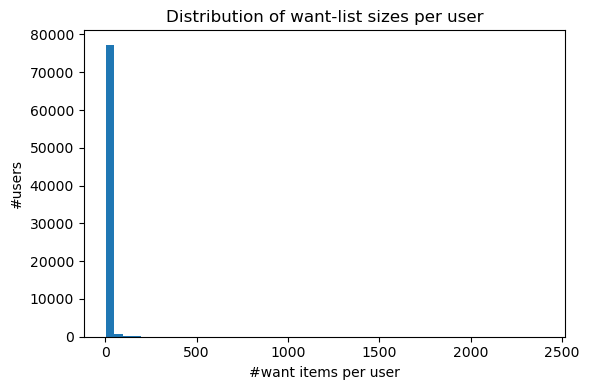

In [4]:
n_users = interactions_df["user_id"].nunique()
n_items = interactions_df["item_id"].nunique()
print(f"#users: {n_users:,}")
print(f"#items: {n_items:,}")

print("\nInteractions per list_type:")
display(interactions_df["list_type"].value_counts())

# Count 'want' items per user
want_df = interactions_df[interactions_df["list_type"] == "want"].copy()
want_per_user = want_df.groupby("user_id")["item_id"].nunique()

print("\nSummary of #want items per user:")
display(want_per_user.describe())

plt.figure(figsize=(6,4))
plt.hist(want_per_user, bins=50)
plt.xlabel("#want items per user")
plt.ylabel("#users")
plt.title("Distribution of want-list sizes per user")
plt.tight_layout()
plt.show()

In [5]:
# Count total interactions per user and per item (any list_type)
interactions_per_user = interactions_df.groupby("user_id")["item_id"].nunique()
interactions_per_item = interactions_df.groupby("item_id")["user_id"].nunique()

print("Users with at least one 'want' item:", (want_per_user > 0).sum())
print("Users with no 'want' items:", (want_per_user == 0).sum() if len(want_per_user) else "N/A")

Users with at least one 'want' item: 78538
Users with no 'want' items: 0


We will restrict our predictive task to **users who have at least one `want` item**, so that we have clear positive examples.


### Build user-centric lookup structures

For efficient negative sampling and feature computation, we construct:

- `user_lists[user_id][list_type] = set(item_ids)` for each list type
- `global_items`: the set of all items seen in any list
- `item_want_popularity[item_id]`: how many users have this item in `want`


In [6]:
# Build user_lists: user -> {list_type -> set(items)}
user_lists = defaultdict(lambda: {lt: set() for lt in LIST_TYPES})

for _, row in interactions_df.iterrows():
    u = row["user_id"]
    i = row["item_id"]
    lt = row["list_type"]
    user_lists[u][lt].add(i)

# Global item sets
global_items_any = set(interactions_df["item_id"].unique())
global_items_want = set(want_df["item_id"].unique())

# Item popularity in 'want' lists
item_want_popularity = Counter(want_df["item_id"])

print(f"Users in user_lists: {len(user_lists):,}")
print(f"Items in any list: {len(global_items_any):,}")
print(f"Items in want lists: {len(global_items_want):,}")

Users in user_lists: 128,152
Items in any list: 352,865
Items in want lists: 165,215


## 3. Predictive task and dataset construction

**Task:** Given a user \(u\) and item \(i\), predict whether \(i\) is in the user's `want` list.

- **Positive instances:** all \((u, i)\) pairs with \(i \in \text{want}_u\)
- **Negative instances:** sampled \((u, j)\) pairs such that \(j\) is not in the user's `want` list

To keep the dataset manageable and balanced, we will sample a fixed number of negatives per positive:
- `NEG_PER_POS = 4` (i.e., 4 negatives for each positive example)


In [8]:
with open("tradesy.json", "rb") as f:
    print(f.read(200))


b'\x1f\x8b\x08\x08T\x1c{[\x02\xfftradesy.json\x00\xc4}\xb9\x8el;\x90\x9c\xaf\xaf\x90w\x1d\x19d\x92\xc9E\xbf"\x8c!A\x824\xc0@2f\x062\x06\xf3\xef\xca<\x8c`u\xb1\xbay\x0f\xab\x0b\xd03^\xe7\xad\xae>+\x97\\"#\xfe\xed\xcf?\xfd\xe3?\xff\xcb?\xff\xf9\xcf\xff\xf1\xdf\xfe\xfc\xb7\xff\xf3\xaf\xff\xf3\x7f\xfd\x8b\x99\xff\xe5\x1f\xfe\xd3\x7f\xfc\xf3\xcf\xff\xe3\x9f\xfe\xe9\x1f\xff\xf7\xff\xe4?\xff\xef\x7f\xfd\xdf\x8f_\xfd\x9f\x7f\xfa\xefn\xffI\x7f\xec_\xf2\xe7\x1f\xfe\xdd~\xfc\xeb?\xfag\x7f\xe2\x9f\x7f\xff\x0f\xff\xf6\xedA\xff\xe4R\xfc\xfbY\xfb\xf8Q\xaf\x1f\xb9\xff\xb9{\xba\x18\xb2\xffI\x0ci\xfcx>\xb3\xfc|\xe6V\xaf?l'


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd

NEG_PER_POS = 4

# Precompute global items list as a NumPy array for fast sampling
global_items_list = np.array(list(global_items_any))


def sample_training_pairs(user_lists, global_items_list, neg_per_pos=4):
    pos_rows = []
    neg_rows = []

    # tqdm progress bar over users
    for u, lists in tqdm(user_lists.items(), desc="Sampling user-item pairs", unit="user"):
        want_items = lists["want"]
        if not want_items:
            continue

        want_items_list = list(want_items)
        want_set = set(want_items)  # fast membership

        for i in want_items_list:
            # Positive sample
            pos_rows.append((u, i, 1))

            # Draw negative samples
            neg_samples = []
            while len(neg_samples) < neg_per_pos:
                cand = np.random.choice(global_items_list)
                if cand not in want_set:
                    neg_samples.append(cand)

            for j in neg_samples:
                neg_rows.append((u, j, 0))

    df = pd.DataFrame(
        pos_rows + neg_rows,
        columns=["user_id", "item_id", "label"]
    )
    return df


# ---- RUN THE SAMPLER ----
pairs_df = sample_training_pairs(user_lists, global_items_list, NEG_PER_POS)
print(f"Constructed {len(pairs_df):,} user–item training pairs.")
pairs_df.head()

Sampling user-item pairs:  10%|▉         | 12522/128152 [00:00<00:07, 16325.61user/s]

In [ ]:
print("Label distribution (1=want, 0=not want):")
display(pairs_df["label"].value_counts(normalize=True).rename("proportion"))

## 4. Feature engineering

For each \((u, i)\) pair, we construct simple, interpretable features:

- **User-side features**
  - `user_total_items`: total #items across all lists (`bought` + `selling` + `want` + `sold`)
  - `user_want_count`: #want items for user
- **Item-side features**
  - `item_want_pop`: how many users have item in their `want` list
- **User–item interaction features**
  - `in_bought`: 1 if item is in user's `bought` list, else 0
  - `in_selling`: 1 if item is in user's `selling` list, else 0
  - `in_sold`: 1 if item is in user's `sold` list, else 0

These are simple but already reflect meaningful structure:
- Users who put many items in `want` might be more likely to mark new items as `want`
- Items that are popular in `want` may also be likely candidates
- Previous interactions (e.g., selling/bought/sold) with an item may correlate with interest


In [ ]:
# Precompute user_total_items and user_want_count
user_total_items = {}
user_want_count = {}

for u, lists in user_lists.items():
    all_items_u = set().union(*lists.values())
    user_total_items[u] = len(all_items_u)
    user_want_count[u] = len(lists["want"])

# Convert item_want_popularity counter to a dict with default 0
item_want_pop_dict = defaultdict(int, item_want_popularity)


def build_feature_columns(pairs_df, user_lists, user_total_items, user_want_count, item_want_pop_dict):
    feats = {}
    feats["user_total_items"] = pairs_df["user_id"].map(lambda u: user_total_items.get(u, 0))
    feats["user_want_count"] = pairs_df["user_id"].map(lambda u: user_want_count.get(u, 0))
    feats["item_want_pop"] = pairs_df["item_id"].map(lambda i: item_want_pop_dict[i])

    # Membership features
    def in_list(u, i, list_name):
        return int(i in user_lists[u][list_name]) if u in user_lists else 0

    feats["in_bought"] = [
        in_list(u, i, "bought") for u, i in zip(pairs_df["user_id"], pairs_df["item_id"])
    ]
    feats["in_selling"] = [
        in_list(u, i, "selling") for u, i in zip(pairs_df["user_id"], pairs_df["item_id"])
    ]
    feats["in_sold"] = [
        in_list(u, i, "sold") for u, i in zip(pairs_df["user_id"], pairs_df["item_id"])
    ]

    feat_df = pd.DataFrame(feats)
    return feat_df


feature_df = build_feature_columns(pairs_df, user_lists, user_total_items, user_want_count, item_want_pop_dict)
print("Feature matrix shape:", feature_df.shape)
feature_df.head()

### Train/validation split

We now split the \((u, i)\) pairs into:

- **Train set:** 80%
- **Validation set:** 20%

We stratify by the label to preserve the positive/negative ratio.


In [ ]:
X = feature_df
y = pairs_df["label"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Train size:", X_train.shape, "Val size:", X_val.shape)
print("Train positive rate:", y_train.mean(), "Val positive rate:", y_val.mean())

## 5. Modeling and evaluation

We will compare:

1. **Random baseline** – random scores for each pair  
2. **Popularity baseline** – uses only `item_want_pop`  
3. **Logistic regression** – uses all engineered features

We evaluate each using:

- Accuracy
- Precision
- Recall
- F1-score
- ROC-AUC


In [ ]:
def evaluate_predictions(y_true, y_pred, y_proba=None, label="model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
    }
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
        except ValueError:
            auc = float("nan")
        metrics["roc_auc"] = auc

    print(f"=== Evaluation: {label} ===")
    for k, v in metrics.items():
        print(f"{k:10s}: {v:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print()
    return metrics

In [ ]:
# 5.1 Random baseline

rand_scores = np.random.rand(len(y_val))
rand_preds = (rand_scores >= 0.5).astype(int)
rand_metrics = evaluate_predictions(y_val, rand_preds, rand_scores, label="Random baseline")

In [ ]:
# 5.2 Popularity baseline (item_want_pop only)

item_pop_val = X_val["item_want_pop"].values.astype(float)
# Normalize scores for ROC-AUC stability
if item_pop_val.max() > 0:
    pop_scores = item_pop_val / item_pop_val.max()
else:
    pop_scores = item_pop_val

pop_preds = (pop_scores >= 0.5).astype(int)  # simple threshold; can be tuned
pop_metrics = evaluate_predictions(y_val, pop_preds, pop_scores, label="Item popularity baseline")

In [ ]:
# 5.3 Logistic Regression model

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

log_reg = LogisticRegression(max_iter=10_000, random_state=RANDOM_SEED)
log_reg.fit(X_train_scaled, y_train)

val_proba_lr = log_reg.predict_proba(X_val_scaled)[:, 1]
val_pred_lr = (val_proba_lr >= 0.5).astype(int)

lr_metrics = evaluate_predictions(y_val, val_pred_lr, val_proba_lr, label="Logistic Regression")

### 5.4 Summary comparison

We summarize the performance of:

- Random baseline  
- Item popularity baseline  
- Logistic regression  

This allows us to demonstrate that our model meaningfully improves upon naive baselines.


In [ ]:
comparison_rows = []

def add_row(name, metrics_dict):
    row = {"model": name}
    row.update(metrics_dict)
    comparison_rows.append(row)

add_row("Random baseline", rand_metrics)
add_row("Item popularity", pop_metrics)
add_row("Logistic Regression", lr_metrics)

results_df = pd.DataFrame(comparison_rows)
results_df

## 6. Optional: Ranking metrics (Precision@k)

For recommender systems, it's often more appropriate to evaluate **rankings** rather than just binary classification.

A simple protocol:

1. For each user in the validation set, collect all \((u, i)\) pairs in the validation split.
2. Rank them by the model's score \(\hat{p}(y=1 \mid u, i)\).
3. Compute **Precision@k** and **Recall@k** for each user and average.

Below is a simple implementation of Precision@k using the logistic regression scores.


In [ ]:
def precision_at_k_per_user(pairs_df, scores, k=10):
    df = pairs_df.copy()
    df["score"] = scores
    # group by user_id and compute precision@k
    precisions = []
    for u, group in df.groupby("user_id"):
        group = group.sort_values("score", ascending=False)
        top_k = group.head(k)
        if len(top_k) == 0:
            continue
        prec_k = top_k["label"].mean()  # fraction of positives in top-k
        precisions.append(prec_k)
    if not precisions:
        return float("nan"), 0
    return float(np.mean(precisions)), len(precisions)


# Build a validation pairs DataFrame aligned with scores
val_pairs = pairs_df.iloc[y_val.index]  # same indexing as X_val/y_val
p_at_5, n_users_eval = precision_at_k_per_user(val_pairs, val_proba_lr, k=5)
p_at_10, _ = precision_at_k_per_user(val_pairs, val_proba_lr, k=10)

print(f"Precision@5 (logistic regression): {p_at_5:.4f} over {n_users_eval} users")
print(f"Precision@10 (logistic regression): {p_at_10:.4f}")

## 7. Discussion and extensions

### 7.1 Interpretation of results

- The **random baseline** represents a model with no knowledge of users or items.
- The **item popularity baseline** captures a simple but powerful signal: items that many users want are more likely to be wanted by a new user.
- The **logistic regression model** combines user-level, item-level, and user–item interaction features, and should outperform both baselines if those signals are informative.

Key observations you might make (depending on your actual numbers):

- Logistic regression improves **ROC-AUC** and **F1-score** over popularity alone.
- Users with very large `want` lists may behave differently than users with very few `want` items.
- Items that appear only in `bought`/`sold` might be less likely to be newly wanted, or the opposite, depending on marketplace dynamics.

### 7.2 Possible extensions

To go beyond this baseline analysis, you could:

- Implement **matrix factorization** (e.g., implicit-feedback MF) to learn user/item latent factors and compare against logistic regression.
- Use more sophisticated **negative sampling**, such as sampling "hard negatives" (items popular in general but not wanted by the user).
- Incorporate **item metadata** (e.g., category, brand, price) if available in another file.
- Evaluate additional ranking metrics such as **Recall@k**, **NDCG@k**, or **MAP**.

### 7.3 Related work (high-level)

This dataset is closely related to standard **implicit feedback** recommendation problems studied in the literature, including:

- User–item interaction modeling (Hu, Koren, Volinsky, 2008)
- Bayesian Personalized Ranking (BPR)
- Fashion and e-commerce recommenders using purchase and wishlist data

In your written report and slides, you can:

- Reference classic papers on implicit feedback recommenders
- Compare your findings qualitatively to known properties of such systems
- Discuss limitations (e.g., missing temporal information, unmodeled confounders)

### 7.4 Summary

In this notebook we:

1. Defined a **predictive task** on the Tradesy lists dataset: predicting whether a user will mark an item as `want`.
2. Flattened the nested user–item lists structure into a long-form interaction table.
3. Constructed a labeled dataset with positive (want) and sampled negative user–item pairs.
4. Engineered intuitive features capturing user activity, item popularity, and user–item relationships.
5. Compared several models (random baseline, item popularity, logistic regression) using standard classification metrics and Precision@k.

This analysis forms a solid foundation for your assignment, and can be extended with more advanced models and richer evaluation protocols.
